In [137]:
import pandas as pd
import numpy as np
import json
import glob
from geopy.distance import vincenty as distance
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, IFrame

sns.set_context('notebook', font_scale=1.6)
%matplotlib inline

# Goals

1. Chained Indexing == BAD so STOP
    * Use iloc, loc
2. Introduce concept of chained operations
2. Best methods in chained operations:
    * query
    * assign
    * pipe
    * merge
    * groupby

# Load the data

In [4]:
def load_divvy_data():
    # load trip data from multiple csv files
    dfs = []
    for fn in glob.iglob('divvy_data/Divvy_Trips*.csv'):
        dfs.append(pd.read_csv(fn, parse_dates=['starttime', 'stoptime']))
    trips = pd.concat(dfs)
    
    # load stations from csv
    stations = pd.read_csv('divvy_data/Divvy_Stations_2016_Q1Q2.csv')
    return trips, stations


trips, stations = load_divvy_data()

print trips.info()
display(trips.head())

print '\n\n', stations.info()
display(stations.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1469740 entries, 0 to 396912
Data columns (total 12 columns):
trip_id              1469740 non-null int64
starttime            1469740 non-null datetime64[ns]
stoptime             1469740 non-null datetime64[ns]
bikeid               1469740 non-null int64
tripduration         1469740 non-null int64
from_station_id      1469740 non-null int64
from_station_name    1469740 non-null object
to_station_id        1469740 non-null int64
to_station_name      1469740 non-null object
usertype             1469740 non-null object
gender               1146765 non-null object
birthyear            1146915 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(5), object(4)
memory usage: 145.8+ MB
None


,trip_id,starttime,stoptime,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
0,9379901,2016-04-30 23:59:00,2016-05-01 00:11:00,21,733,123,California Ave & Milwaukee Ave,374,Western Ave & Walton St,Subscriber,Male,1982.0
1,9379900,2016-04-30 23:58:00,2016-05-01 00:07:00,3583,556,349,Halsted St & Wrightwood Ave,165,Clark St & Grace St,Subscriber,Male,1991.0
2,9379899,2016-04-30 23:58:00,2016-05-01 00:02:00,4557,253,59,Wabash Ave & Roosevelt Rd,273,Michigan Ave & 18th St,Subscriber,Male,1984.0
3,9379898,2016-04-30 23:54:00,2016-05-01 00:08:00,2443,802,289,Wells St & Concord Ln,199,Wabash Ave & Grand Ave,Subscriber,Male,1978.0
4,9379897,2016-04-30 23:52:00,2016-05-01 00:11:00,50,1146,239,Western Ave & Leland Ave,227,Southport Ave & Waveland Ave,Customer,NaN,NaN




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535 entries, 0 to 534
Data columns (total 6 columns):
id             535 non-null int64
name           535 non-null object
latitude       535 non-null float64
longitude      535 non-null float64
dpcapacity     535 non-null int64
online_date    535 non-null object
dtypes: float64(2), int64(2), object(2)
memory usage: 25.1+ KB
None


,id,name,latitude,longitude,dpcapacity,online_date
0,456,2112 W Peterson Ave,41.991178,-87.683593,15,5/12/2015
1,101,63rd St Beach,41.781016,-87.576120,23,4/20/2015
2,109,900 W Harrison St,41.874675,-87.650019,19,8/6/2013
3,21,Aberdeen St & Jackson Blvd,41.877726,-87.654787,15,6/21/2013
4,80,Aberdeen St & Monroe St,41.880456,-87.653929,19,6/26/2013


# Chained[Index][ing] == BAD so STOP

### Pandas slice / view:
Portion or Cut of the dataframe which shares the location in memory with original dataframe.
```python
df['column']
```

### Pandas copy:
Copy of the original dataframe into a new location in memory. Any manipulations of a copied dataframe have no impact on original dataframe.

```python
df[df.column > x]['column']
```

In [41]:
# prepare example data for demo
example = trips.head(5).copy()
example['length_of_trip'] = 'short_trip'
example

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,length_of_trip
0,9379901,2016-04-30 23:59:00,2016-05-01 00:11:00,21,733,123,California Ave & Milwaukee Ave,374,Western Ave & Walton St,Subscriber,Male,1982.0,short_trip
1,9379900,2016-04-30 23:58:00,2016-05-01 00:07:00,3583,556,349,Halsted St & Wrightwood Ave,165,Clark St & Grace St,Subscriber,Male,1991.0,short_trip
2,9379899,2016-04-30 23:58:00,2016-05-01 00:02:00,4557,253,59,Wabash Ave & Roosevelt Rd,273,Michigan Ave & 18th St,Subscriber,Male,1984.0,short_trip
3,9379898,2016-04-30 23:54:00,2016-05-01 00:08:00,2443,802,289,Wells St & Concord Ln,199,Wabash Ave & Grand Ave,Subscriber,Male,1978.0,short_trip
4,9379897,2016-04-30 23:52:00,2016-05-01 00:11:00,50,1146,239,Western Ave & Leland Ave,227,Southport Ave & Waveland Ave,Customer,NaN,NaN,short_trip


### Poor form using index chaining

In [42]:
example[example.tripduration > 1000]['length_of_trip'] = 'long_trip'
example

/Users/scottcronin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,trip_id,starttime,stoptime,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,length_of_trip
0,9379901,2016-04-30 23:59:00,2016-05-01 00:11:00,21,733,123,California Ave & Milwaukee Ave,374,Western Ave & Walton St,Subscriber,Male,1982.0,short_trip
1,9379900,2016-04-30 23:58:00,2016-05-01 00:07:00,3583,556,349,Halsted St & Wrightwood Ave,165,Clark St & Grace St,Subscriber,Male,1991.0,short_trip
2,9379899,2016-04-30 23:58:00,2016-05-01 00:02:00,4557,253,59,Wabash Ave & Roosevelt Rd,273,Michigan Ave & 18th St,Subscriber,Male,1984.0,short_trip
3,9379898,2016-04-30 23:54:00,2016-05-01 00:08:00,2443,802,289,Wells St & Concord Ln,199,Wabash Ave & Grand Ave,Subscriber,Male,1978.0,short_trip
4,9379897,2016-04-30 23:52:00,2016-05-01 00:11:00,50,1146,239,Western Ave & Leland Ave,227,Southport Ave & Waveland Ave,Customer,NaN,NaN,short_trip


### Best Practice using loc

In [43]:
example.loc[example.tripduration > 1000, 'length_of_trip'] = 'long_trip'
example

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,length_of_trip
0,9379901,2016-04-30 23:59:00,2016-05-01 00:11:00,21,733,123,California Ave & Milwaukee Ave,374,Western Ave & Walton St,Subscriber,Male,1982.0,short_trip
1,9379900,2016-04-30 23:58:00,2016-05-01 00:07:00,3583,556,349,Halsted St & Wrightwood Ave,165,Clark St & Grace St,Subscriber,Male,1991.0,short_trip
2,9379899,2016-04-30 23:58:00,2016-05-01 00:02:00,4557,253,59,Wabash Ave & Roosevelt Rd,273,Michigan Ave & 18th St,Subscriber,Male,1984.0,short_trip
3,9379898,2016-04-30 23:54:00,2016-05-01 00:08:00,2443,802,289,Wells St & Concord Ln,199,Wabash Ave & Grand Ave,Subscriber,Male,1978.0,short_trip
4,9379897,2016-04-30 23:52:00,2016-05-01 00:11:00,50,1146,239,Western Ave & Leland Ave,227,Southport Ave & Waveland Ave,Customer,NaN,NaN,long_trip


Best practices:
* use .loc, .iloc, and if absolutely needed, then .ix
* do not ever chain index operations


http://pandas.pydata.org/pandas-docs/stable/indexing.html#different-choices-for-indexing

# What is Operation Chaining???

Applying multiple methods of the pandas class in a linear fashion.


Shortest five trips from each station:

In [63]:
(
    trips
    .groupby(['from_station_name', 'to_station_name'])
    .agg({'tripduration': 'min'})
    .reset_index()
    .sort_values(['from_station_name', 'tripduration'])
    .groupby('from_station_name')
    .head(5)
).head(10)

,from_station_name,to_station_name,tripduration
0,2112 W Peterson Ave,2112 W Peterson Ave,73
23,2112 W Peterson Ave,Maplewood Ave & Peterson Ave,191
32,2112 W Peterson Ave,Western Ave & Granville Ave,214
11,2112 W Peterson Ave,Clark St & Elmdale Ave,379
13,2112 W Peterson Ave,Clark St & Schreiber Ave,389
35,63rd St Beach,63rd St Beach,69
63,63rd St Beach,Museum of Science and Industry,343
45,63rd St Beach,Dorchester Ave & 63rd St,416
66,63rd St Beach,Shore Dr & 55th St,490
67,63rd St Beach,South Shore Dr & 67th St,508


Without operation chaining:

# Useful Methods in Operation Chaining

## .query()

In [186]:
starting_stations = ['Millennium Park', 'Shedd Aquarium']

(
    trips
    .query("tripduration < 60*30")
    .query("usertype == 'Subscriber'")
    .query("'2016-06-01' < starttime < '2016-07-01'")
    .query("from_station_name in @starting_stations")
).head(5)

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
360,10426207,2016-06-30 22:35:00,2016-06-30 22:44:00,2826,570,90,Millennium Park,112,Green St & Randolph St,Subscriber,Male,1987.0
449,10426086,2016-06-30 22:22:00,2016-06-30 22:49:00,2881,1595,90,Millennium Park,171,May St & Cullerton St,Subscriber,Male,1986.0
603,10425875,2016-06-30 22:02:00,2016-06-30 22:18:00,3863,986,90,Millennium Park,255,Indiana Ave & Roosevelt Rd,Subscriber,Female,1977.0
844,10425589,2016-06-30 21:34:00,2016-06-30 21:55:00,867,1270,90,Millennium Park,341,Adler Planetarium,Subscriber,Male,1981.0
897,10425518,2016-06-30 21:28:00,2016-06-30 21:34:00,812,364,90,Millennium Park,191,Canal St & Monroe St (*),Subscriber,Male,1969.0


## .assign()

In [185]:
(
    trips
    .assign(age=lambda df: 2016 - df.birthyear)
    .assign(tripduration = lambda df: df.tripduration / 60.)
).head(5)

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,age
0,9379901,2016-04-30 23:59:00,2016-05-01 00:11:00,21,12.216667,123,California Ave & Milwaukee Ave,374,Western Ave & Walton St,Subscriber,Male,1982.0,34.0
1,9379900,2016-04-30 23:58:00,2016-05-01 00:07:00,3583,9.266667,349,Halsted St & Wrightwood Ave,165,Clark St & Grace St,Subscriber,Male,1991.0,25.0
2,9379899,2016-04-30 23:58:00,2016-05-01 00:02:00,4557,4.216667,59,Wabash Ave & Roosevelt Rd,273,Michigan Ave & 18th St,Subscriber,Male,1984.0,32.0
3,9379898,2016-04-30 23:54:00,2016-05-01 00:08:00,2443,13.366667,289,Wells St & Concord Ln,199,Wabash Ave & Grand Ave,Subscriber,Male,1978.0,38.0
4,9379897,2016-04-30 23:52:00,2016-05-01 00:11:00,50,19.100000,239,Western Ave & Leland Ave,227,Southport Ave & Waveland Ave,Customer,NaN,NaN,NaN


## .pipe()

In [182]:
def get_coords(x):
    return (x.latitude, x.longitude)

def get_dist(x):
    dist = distance(x.coords_x, x.coords_y)
    return dist.miles

trip_dists = (
    trips
    .assign(tripduration=lambda df: df.tripduration / 60.)
    .query("tripduration <= 30.0")
    .loc[:, ['trip_id', 'starttime', 'tripduration',
             'from_station_id', 'to_station_id',
             'from_station_name', 'to_station_name']]
    .merge(
        stations
        .assign(coords=lambda df: df.apply(get_coords, axis=1))
        .loc[:, ['id', 'coords']],
        how='left',
        left_on=['from_station_id'],
        right_on=['id'])

    .merge(
        stations
        .assign(coords=lambda df: df.apply(get_coords, axis=1))
        .loc[:, ['id', 'coords']],
        how='left',
        left_on=['to_station_id'],
        right_on=['id'])
    
    .assign(dist=lambda df: df.apply(get_dist, axis=1))
    .drop(['id_x', 'id_y', 'from_station_id',
           'to_station_id'], axis=1)
    .sort_values('dist', ascending=False)
)

trip_dists.head(10)

,trip_id,starttime,tripduration,from_station_name,to_station_name,coords_x,coords_y,dist
1143551,8847858,2016-03-02 22:39:00,23.233333,Canal St & Madison St,Broadway & Berwyn Ave,"(41.882091, -87.639833)","(41.978353, -87.659753)",6.722556
1205512,8762801,2016-02-18 15:29:00,29.450000,Streeter Dr & Grand Ave,Lakefront Trail & Bryn Mawr Ave,"(41.892278, -87.612043)","(41.984037, -87.65231)",6.664203
1100869,8905651,2016-03-10 13:06:00,28.450000,Lincoln Ave & Winona St,St. Clair St & Erie St,"(41.974911, -87.692503)","(41.894448, -87.622663)",6.617618
514954,9418301,2016-05-04 14:53:00,24.200000,St. Clair St & Erie St,Lincoln Ave & Winona St,"(41.894448, -87.622663)","(41.974911, -87.692503)",6.617618
1130370,8866779,2016-03-06 16:12:00,29.150000,Lake Shore Dr & Ohio St,Lakefront Trail & Bryn Mawr Ave,"(41.89257, -87.614492)","(41.984037, -87.65231)",6.606735
1041417,8985080,2016-03-20 16:18:00,29.750000,Lake Shore Dr & Monroe St,Shore Dr & 55th St,"(41.880958, -87.616743)","(41.795212, -87.580715)",6.203084
123834,9207102,2016-04-16 15:57:00,27.366667,Lake Shore Dr & Monroe St,Shore Dr & 55th St,"(41.880958, -87.616743)","(41.795212, -87.580715)",6.203084
124423,9206291,2016-04-16 15:27:00,29.250000,Shore Dr & 55th St,Lake Shore Dr & Monroe St,"(41.795212, -87.580715)","(41.880958, -87.616743)",6.203084
132672,9194603,2016-04-15 18:14:00,29.950000,Lakefront Trail & Bryn Mawr Ave,Mies van der Rohe Way & Chestnut St,"(41.984037, -87.65231)","(41.898587, -87.621915)",6.101931
345743,9652843,2016-05-22 09:21:00,28.400000,Broadway & Berwyn Ave,St. Clair St & Erie St,"(41.978353, -87.659753)","(41.894448, -87.622663)",6.098144


In [183]:
def show_google_maps(df, index):
    lat_x, long_x = df.loc[index, 'coords_x']
    lat_y, long_y = df.loc[index, 'coords_y']

    url = ("https://www.google.com/maps/embed?pb=!1m26!1m12!1m3"
           "!1d94984.41444534011!2d-87.71636148530142!"
           "3d41.93020071811045!2m3!1f0!2f0!3f0!3m2!1i1024!2i768!"
           "4f13.1!4m11!3e1!4m4!2s{lat_x}%2C+{long_x}!3m2!1d"
           "41.882090999999996!2d{long_x}!4m4!2s{lat_y}%2C+"
           "{long_y}!3m2!1d{lat_y}!2d{long_y}"
           "!5e0!3m2!1sen!2sus!4v1470808071878"
           ).format(lat_x=lat_x, long_x=long_x,
                    lat_y=lat_y, long_y=long_y)
    
    display(IFrame(url, width=600, height=450))


# show 3 longest trips on Divvys in < 30 minutes
for i in trip_dists.index[:3]:
    show_google_maps(trip_dists, i)

## .groupby() + .merge()

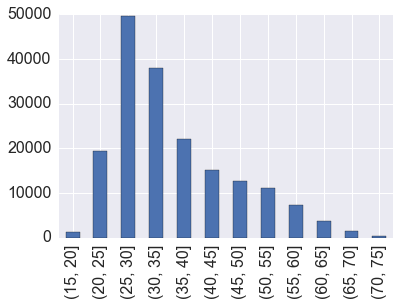

In [59]:
t = trips.copy()
t['age'] = 2016 - t['birthyear']
t['age_cut'] = pd.cut(t['age'], bins=np.arange(15, 80, 5))
t['age_cut'].value_counts().sort_index().plot(kind='bar')
plt.show()

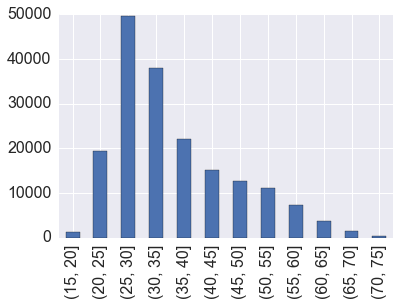

In [79]:
(
    trips
    .assign(age=lambda df: 2016 - df.birthyear)
    .assign(age_cut=lambda df: pd.cut(df.age, bins=np.arange(15, 80, 5)))
    .loc[:, 'age_cut']
    .value_counts()
    .sort_index()
).plot(kind='bar')

plt.show()

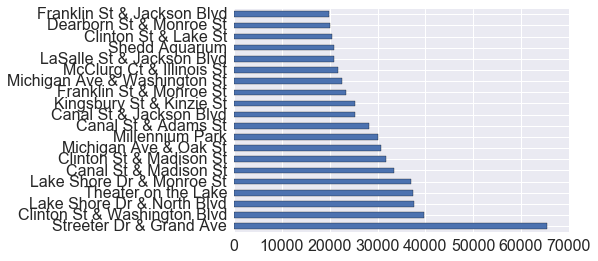

In [72]:
(
    trips
    .loc[:, ['from_station_name', 'to_station_name']]
    .stack()
    .value_counts()
    .head(20)
).plot(kind='barh')

plt.show()